## What is the decision tree?

![](https://i.imgur.com/5C4ryqb.png)

In [1]:
# Import package
import matplotlib.pyplot as plt
from sklearn import datasets

# Loading data
iris = datasets.load_iris()
X = iris['data'][:, 2:]
y = iris['target']
X.shape, y.shape

((150, 2), (150,))

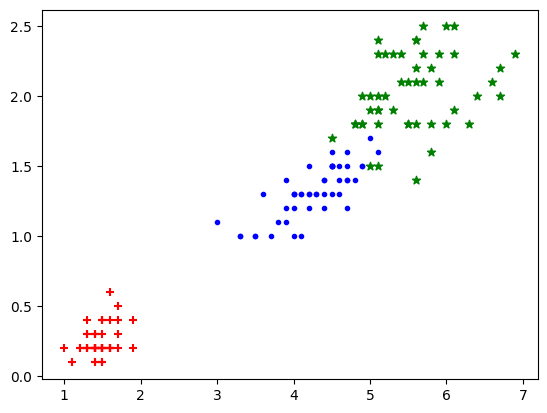

In [2]:
# plot data
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', marker='+')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', marker='.')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='g', marker='*')
plt.show()

In [3]:
# Create model
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(max_depth=2, criterion='entropy')
dt_classifier.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [4]:
import numpy as np


def plot_decision_boundary(model, axis):
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1)
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

C:\Users\myxc\AppData\Local\Temp\ipykernel_28680\3316778104.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


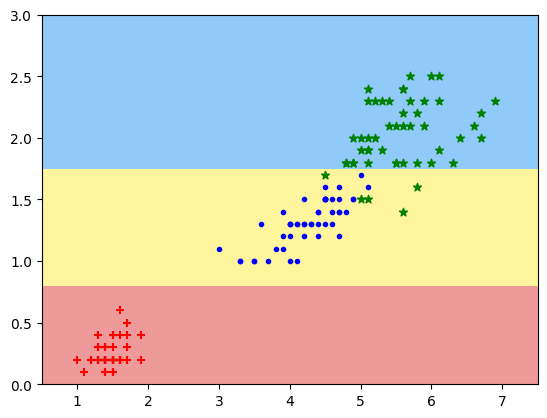

In [5]:
plot_decision_boundary(dt_classifier, axis=[.5, 7.5, 0, 3])
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', marker='+')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', marker='.')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='g', marker='*')
plt.show()

![](https://i.imgur.com/xqTUDta.png)

- 非参数学习算法
- 可以解决分类问题
- 天然可以解决多分类问题
- 也可以解决回归问题
- 非常好的可解释性

## 信息熵

熵在信息论中代表随机变量不确定度的度量。

熵越大，数据的不确定性越高；熵越小，数据的不确定性越低。

![](https://i.imgur.com/RfZ8Yvb.png)

特别的，针对二分类问题：

$$H = - x \log ( x ) - ( 1 - x ) \log ( 1 - x )$$

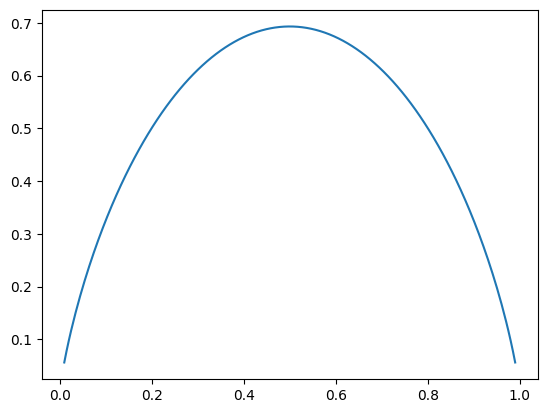

In [6]:
def binary_entropy(p):
    return -p * np.log(p) - (1 - p) * np.log(1 - p)


x = np.linspace(0.01, 0.99, 200)

plt.plot(x, binary_entropy(x))
plt.show()
# 由图中可以看出来，针对二分类问题，在“五五分”的情况下，信息熵最大；而在“一家独大”的情况下，信息熵会尽力小。

![](https://i.imgur.com/ET6yWjJ.png)

## 模拟使用信息熵划分

In [7]:
def split_data(X, y, d, value):
    """
    传入一个feature矩阵与一个label矩阵，然后根据feature矩阵d列的值以value为界限进行划分
    :param X: feature矩阵
    :param y: label向量
    :param d: 以哪一列进行划分
    :param value: 划分界限
    :return: 返回经过划分的feature矩阵与label矩阵
    """
    index_l = (X[:, d] <= value)
    index_r = (X[:, d] > value)
    return X[index_l], X[index_r], y[index_l], y[index_r]


from collections import Counter


def calc_entropy(y):
    """
    传入一个label向量，然后根据其中的label值计算其信息熵。
    :param y: label向量（一维张量）
    :return: 返回计算的信息熵
    """
    counter = Counter(y)
    res = 0
    for num in counter.values():
        p = num / len(y)
        res += -p * np.log(p)
    return res


def try_split(X, y):
    best_entropy = np.inf
    best_d, best_v = -1, -1
    for d in range(X.shape[1]):
        sort_index = np.argsort(X[:, d])
        for i in range(1, len(X)):
            if X[sort_index[i - 1], d] != X[sort_index[i], d]:
                v = (X[sort_index[i - 1], d] + X[sort_index[i], d]) / 2
                X_l, X_r, y_l, y_r = split_data(X, y, d, v)
                e = calc_entropy(y_l) + calc_entropy(y_r)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v

    return best_entropy, best_d, best_v


best_entropy, best_d, best_v = try_split(X, y)
best_entropy, best_d, best_v
# 结果显示：best_d=0，即对于数据集X来说，在第0列数据中以best_v=2.45为界限进行划分，所得到的信息熵最小，best_entropy=0.69315

(0.6931471805599453, 0, 2.45)

In [8]:
X_0_l, X_0_r, y_0_l, y_0_r = split_data(X, y, best_d, best_v)

In [9]:
calc_entropy(y_0_l)
# 经过第一次划分后，X_0_l的信息熵已经为0，说明X_0_l中的数据全部为1类，完成了划分。

0.0

In [10]:
calc_entropy(y_0_r)
# 经过第一次划分，X_0_r中信息熵还比较大，说明其中的数据点还比较”混乱”——含有多个不同的label，需要继续进行划分

0.6931471805599453

In [11]:
try_split(X_0_r, y_0_r)
# 结果显示：best_d=1，即对于数据集X_0_r来说，在第1列数据中以best_v=1.75为界限进行划分，所得到的信息熵最小，best_entropy=0.413

(0.4132278899361904, 1, 1.75)

In [12]:
X_1_l, X_1_r, y_1_l, y_1_r = split_data(X_0_r, y_0_r, 1, 1.75)

In [13]:
calc_entropy(y_1_l)
# 经过第二次划分，X_1_l的信信息熵为0.308

0.30849545083110386

In [14]:
calc_entropy(y_1_r)
# 经过第二次划分，X_1_r的信信息熵为0.104，已经比较小了，说明其数据中的“杂质”较少。

0.10473243910508653

![](https://i.imgur.com/T6c6d5C.png)

## 基尼系数

$$G = 1 - \sum _ { i = 1 } ^ { k } p _ { i } ^ { 2 }$$

 ![](https://i.imgur.com/wT0WYHt.png)


特别地，针对二分类问题：

$$\left. \begin{array}  { l  }  { G = 1 - x ^ { 2 } - ( 1 , - x ) ^ { 2 } } \\ { = 1 - x ^ { 2 } - 1 + 2 x - x ^ { 2 } } \\ { = - 2 x ^ { 2 } + 2 x } \end{array} \right.$$

基尼系数是一个开口向下的二次函数图像，在x=0.5处取得最小值。

C:\Users\myxc\AppData\Local\Temp\ipykernel_28680\3316778104.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


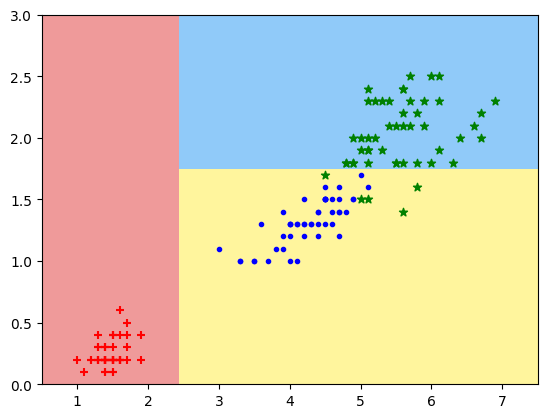

In [15]:
dt_classifier = DecisionTreeClassifier(max_depth=2, criterion='gini')
dt_classifier.fit(X, y)

plot_decision_boundary(dt_classifier, axis=[.5, 7.5, 0, 3])
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', marker='+')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', marker='.')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='g', marker='*')
plt.show()

In [16]:
def calc_gini(y):
    """
    传入一个label向量，然后根据其中的label值计算其基尼系数。
    :param y: label向量（一维张量）
    :return: 返回计算的基尼系数
    """
    counter = Counter(y)
    res = 1
    for num in counter.values():
        p = num / len(y)
        res -= p ** 2
    return res


def try_split(X, y, fun=calc_entropy):
    best_entropy = np.inf
    best_d, best_v = -1, -1
    for d in range(X.shape[1]):
        sort_index = np.argsort(X[:, d])
        for i in range(1, len(X)):
            if X[sort_index[i - 1], d] != X[sort_index[i], d]:
                v = (X[sort_index[i - 1], d] + X[sort_index[i], d]) / 2
                X_l, X_r, y_l, y_r = split_data(X, y, d, v)
                e = fun(y_l) + fun(y_r)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v

    return best_entropy, best_d, best_v


try_split(X, y, calc_gini)

(0.5, 0, 2.45)

-熵信息的计算比基尼系数稍慢；
-scikit-learn中默认为基尼系数；
-大多数时候二者没有特别的效果优劣。

## CART和决策树的超参数
CART(Classification And Regression Tree)，根据某一个维度d和某一个阈值v进行二分。

scikit-learn的决策树实现: CART

![](https://i.imgur.com/OEe7jmB.png)

In [17]:
X, y = datasets.make_moons(noise=0.25, random_state=666)
X.shape, y.shape

((100, 2), (100,))

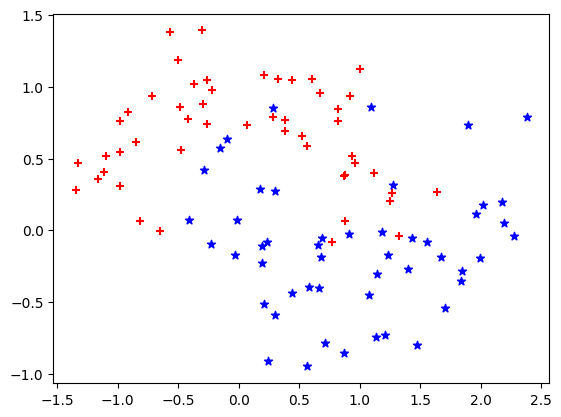

In [18]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='+', color='r')
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='b')
plt.show()

C:\Users\myxc\AppData\Local\Temp\ipykernel_28680\3316778104.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


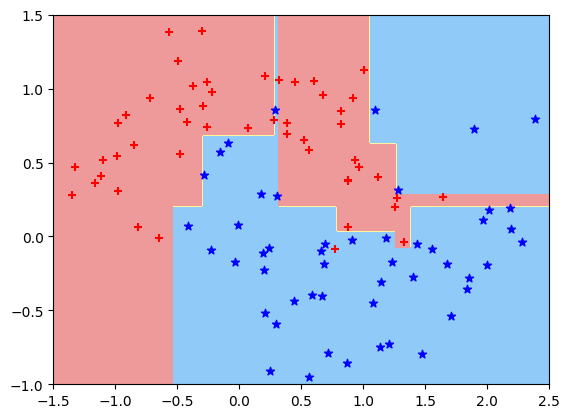

In [19]:
dt_classifier = DecisionTreeClassifier()  # 创建决策树对象时，如果没有定义max_depth，默认会一直划分下去，由下图中可以看出来，显然这个时候产生了过拟合。
dt_classifier.fit(X, y)

plot_decision_boundary(dt_classifier, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='+', color='r')
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='b')
plt.show()

C:\Users\myxc\AppData\Local\Temp\ipykernel_28680\3316778104.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


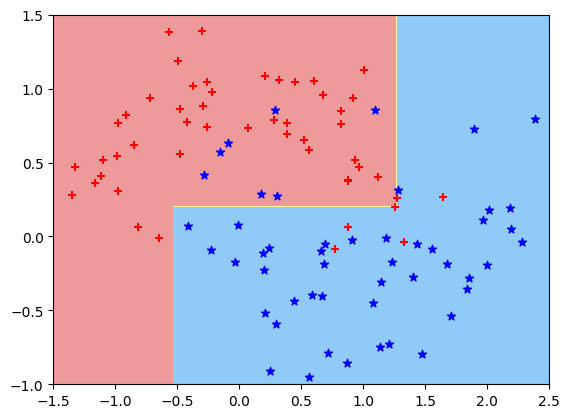

In [20]:
dt_classifier = DecisionTreeClassifier(max_depth=2)  # 定义决策树的最大深度为2
dt_classifier.fit(X, y)

plot_decision_boundary(dt_classifier, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='+', color='r')
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='b')
plt.show()

C:\Users\myxc\AppData\Local\Temp\ipykernel_28680\3316778104.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


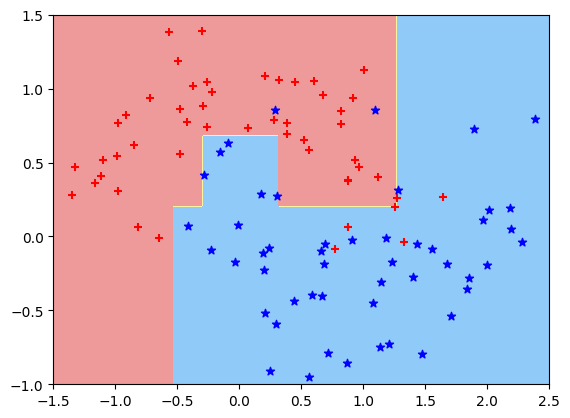

In [21]:
dt_classifier = DecisionTreeClassifier(min_samples_split=10)  # min_samples_split=10定义了当某个区域中有超过10个点时候才进行划分.
dt_classifier.fit(X, y)

plot_decision_boundary(dt_classifier, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='+', color='r')
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='b')
plt.show()

C:\Users\myxc\AppData\Local\Temp\ipykernel_28680\3316778104.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


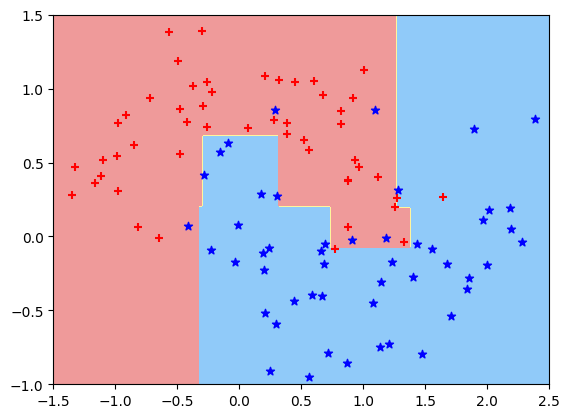

In [22]:
dt_classifier = DecisionTreeClassifier(min_samples_leaf=3)
dt_classifier.fit(X, y)

plot_decision_boundary(dt_classifier, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='+', color='r')
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='b')
plt.show()

C:\Users\myxc\AppData\Local\Temp\ipykernel_28680\3316778104.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


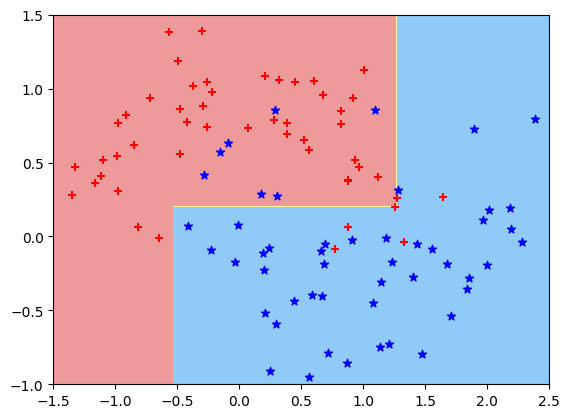

In [23]:
dt_classifier = DecisionTreeClassifier(max_leaf_nodes=4)
dt_classifier.fit(X, y)

plot_decision_boundary(dt_classifier, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='+', color='r')
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='b')
plt.show()

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

- min_samples_split
- min_samples_leaf
- min_weight_fraction_leaf
- max_depth
- max_leaf_nodes
- min_features

## 回归问题

In [24]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

X = data
y = target
X.shape, y.shape

NameError: name 'pd' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((379, 13), (127, 13), (379,), (127,))

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_reg_er = DecisionTreeRegressor()
dt_reg_er.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
dt_reg_er.score(X_test, y_test)

0.6730581146848147

In [ ]:
dt_reg_er.score(X_train, y_train)  # 模型在训练集上的score=1，而在测试集上的score却不尽人意，显然产生了过拟合的情况

1.0

![](https://i.imgur.com/DWtw1IS.png)

https://github.com/liuyubobobo/Play-with-Machine-Learning-Algorithms

决策树的局限性：①决策边界只能为“横平竖直”的直线！！！②对个别数据敏感。

In [ ]:
X = iris['data'][:, 2:]
y = iris['target']
X.shape, y.shape

((150, 2), (150,))

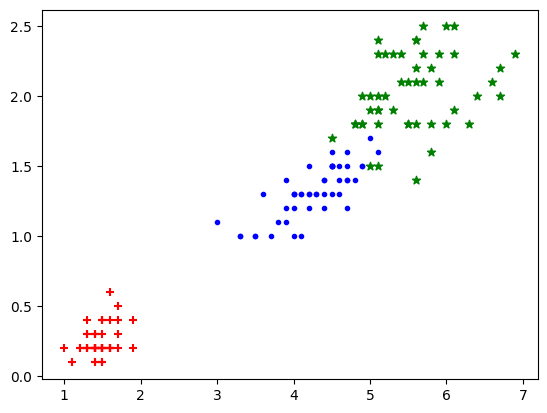

In [ ]:
# plot data
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', marker='+')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', marker='.')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='g', marker='*')
plt.show()

C:\Users\myxc\AppData\Local\Temp\ipykernel_8108\1609706217.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


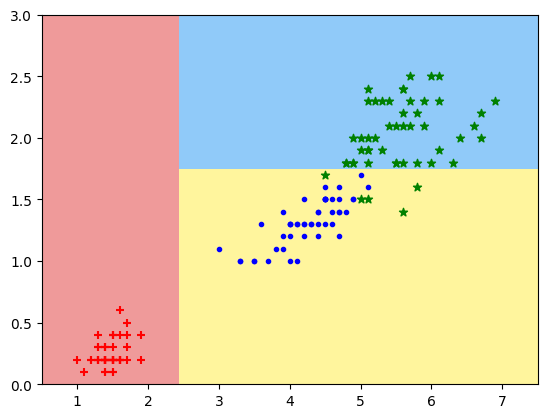

In [ ]:
dt_classifier = DecisionTreeClassifier(max_depth=2, criterion='entropy')
dt_classifier.fit(X, y)

plot_decision_boundary(dt_classifier, axis=[.5, 7.5, 0, 3])
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', marker='+')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', marker='.')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='g', marker='*')
plt.show()

In [ ]:
X_new = np.delete(X, 138, axis=0)
y_new = np.delete(y, 138)

C:\Users\myxc\AppData\Local\Temp\ipykernel_8108\1609706217.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


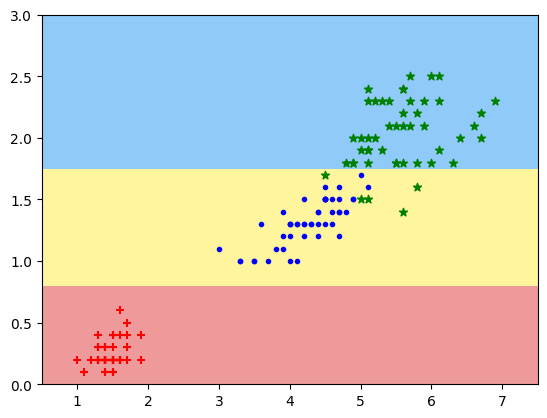

In [ ]:
dt_classifier = DecisionTreeClassifier(max_depth=2, criterion='entropy')
dt_classifier.fit(X_new, y_new)

plot_decision_boundary(dt_classifier, axis=[.5, 7.5, 0, 3])
plt.scatter(X_new[y_new == 0, 0], X_new[y_new == 0, 1], color='r', marker='+')
plt.scatter(X_new[y_new == 1, 0], X_new[y_new == 1, 1], color='b', marker='.')
plt.scatter(X_new[y_new == 2, 0], X_new[y_new == 2, 1], color='g', marker='*')
plt.show()
# 仅仅对数据集删除一个样本，重新建立模型就会发现决策边界发生了改变，对于所有非参数学习都有这个缺点，就是对于个别数据的敏感性！集成学习的方式创建决策树——随机森林